# Sheet 10

## 1 Optimal Transport

### (a)(b)

Suppose we have p sources, q sinks.

Let $\pi$ be a transportation method. $\pi$ is composed of 2 matrix $L$ and $M$. 

The element of $L$, $l_{ij}$, is the path length between the i-th source and the j-th sink. 

The element of $M$, $m_{ij}$, is the mass being transported between the i-th source and the j-th sink.

The cost of $\pi$ is
$$Cost_\pi = \sum_{i, j} l_{ij} m_{ij},$$

Using Einstein summation convention, it can be written as
$$Cost_\pi = l_{ij} m_{ij} = \delta^{jk} (L^T)_{ji} (M)_{ik} = \delta^{jk} (L^T M)_{jk} = Tr(L^T M).$$

The conditions are $\sum_j m_{ij} = a_i$, $\sum_i m_{ij} = b_j$ and $\sum_i a_i = \sum_j b_j = \sum_i \sum_j m_{ij}$.

Optimal transport problem is to minimize $Cost_\pi$, i.e. 
$${\rm minimize  }\quad \sum_{i, j} l_{ij} m_{ij},$$
subject to
$$m_{ij} \geq 0, \quad \sum_j m_{ij} = a_i, \quad \sum_i m_{ij} = b_j, \quad \sum_i a_i = \sum_j b_j = \sum_i \sum_j m_{ij}.$$

or 
$${\rm minimize  }\quad Tr(L^T M),$$
subject to
$$(M)_{ij} \geq 0, \quad {\bm 1}_p^T M = B^T, \quad M{\bm 1}_q = A,$$
where ${\bm 1}_s$ is an s dimensional vector with all elements being 1, $A$ is the mass vector of sources, and $B$ is the mass vector of sinks. The last 2 conditions have already promised $\sum_i a_i = \sum_j b_j$, since $\sum_i a_i = {\bm 1}_p^T A = {\bm 1}_p^T M {\bm 1}_q = B^T {\bm 1}_q = \sum_j b_j$.

In Euclidean space with Euclidean metric, the minimum length of any trajectory between point $x$ and point $y$ is $||x - y||$, which can be reached only the trajectory is a straight line. So the minimum cost of transportation will be $\sum_{i, j} ||x_i - y_j|| m_{ij}$, i.e. the mass should be transported along straight lines between sources and sinks.


In [13]:
import numpy as np

d = 5
num_sources = 10
num_sinks = 20

np.random.seed(42)
mass_sources = np.random.random(num_sources)
mass_sinks = np.random.random(num_sinks)
mass_sources /= np.sum(mass_sources)
mass_sinks /= np.sum(mass_sinks)

coords_sources = np.random.rand(num_sources, d)
coords_sinks = np.random.rand(num_sinks, d)

In [14]:
# TODO: solve the OT problem as linear program

# compute the distance matrix L
L = np.zeros((num_sources, num_sinks))
for i in range(num_sources):
    for j in range(num_sinks):
        L[i, j] = np.linalg.norm(coords_sources[i] - coords_sinks[j])

## 2 Flow matching for generative modeling

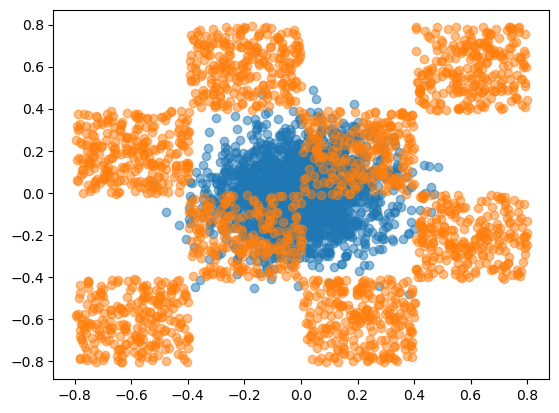

In [15]:
import torch
import matplotlib.pyplot as plt

def generate_checkerboard_sample(num_samples=10, field_size=0.4, num_fields=2, center=True):
    x = torch.rand(num_samples, 2) * field_size
    offset = torch.randint(0, num_fields, (num_samples, 2)) * field_size * 2
    diagonal_shift = torch.randint(0, num_fields, (num_samples, 1)) * field_size
    x += offset + diagonal_shift

    if center:
        x -= torch.mean(x, dim=0)

    return x
    
base_distribution_std = 0.15
num_samples = 2000
x = torch.randn(num_samples, 2) * base_distribution_std
y = generate_checkerboard_sample(num_samples=num_samples)

# show points
plt.scatter(x[:, 0], x[:, 1], alpha=0.5, label='base distribution')
plt.scatter(y[:, 0], y[:, 1], alpha=0.5, label='checkerboard distribution')
plt.show()

In [24]:
# define a model
from torchvision.ops import MLP
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

model = MLP(in_channels=2 + 1, hidden_channels=[512, 512, 512, 512, 2], activation_layer=torch.nn.SiLU)
model.to(device)

# define a loss function
criterion = torch.nn.MSELoss(reduction="none")

# define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# train the model:
num_epochs = 20000  # use fewer epochs if it takes too long
batch_size = 4096
losses = []
for epoch in tqdm(range(num_epochs)):
    x = torch.randn(batch_size, 2) * base_distribution_std
    y = generate_checkerboard_sample(num_samples=batch_size)

    # TODO: implement the training loop

    # randomly gereate a time tensor
    t = torch.rand(batch_size, 1)

    # interpolate the positions at time t
    pos = x * (1 - t) + y * t

    # concatenate the positions with the time tensor
    input = torch.cat([pos, t], dim=1)

    # target velocity field
    v = y - x

    # optimize
    optimizer.zero_grad()
    loss = criterion(model(input), v)
    losses.append(loss.detach().numpy())
    loss.backward()
    optimizer.step()

  0%|          | 0/20000 [00:00<?, ?it/s]


RuntimeError: grad can be implicitly created only for scalar outputs

In [30]:
loss

tensor([[0.6242, 0.0928],
        [0.7760, 0.0262],
        [0.0095, 0.0036],
        ...,
        [0.1205, 0.0345],
        [0.6194, 0.2880],
        [0.1716, 0.6630]], grad_fn=<MseLossBackward0>)

In [17]:
# TODO: run inference with the trained model. 
# Visualize the trajectory of the samples and the final samples at t=1.
# Hint: Use a simple Euler integration scheme to integrate the velocity field with 100 steps.

## 3 Adversarial attacks and AI safety

A probe can be seen as another output channel of the network. Tricking a probe involves modifying the input specifically for some network structure, s.t. the model are tricked to give false response. This is exactly what adversarial attacks do.

In [18]:
'''
Logistric regression in pytorch (needed for backpropagation)
taken from https://github.com/saprmarks/geometry-of-truth/blob/main/probes.py
'''

class LRProbe(torch.nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(d_in, 1, bias=False),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

    def pred(self, x):
        return self(x).round()
    
    def from_data(acts, labels, lr=0.001, weight_decay=0.1, epochs=1000, device='cpu'):
        acts, labels = acts.to(device), labels.to(device)
        probe = LRProbe(acts.shape[-1]).to(device)
        
        opt = torch.optim.AdamW(probe.parameters(), lr=lr, weight_decay=weight_decay)
        for _ in range(epochs):
            opt.zero_grad()
            loss = torch.nn.BCELoss()(probe(acts), labels)
            loss.backward()
            opt.step()
        
        return probe

    def __str__():
        return "LRProbe"

    @property
    def direction(self):
        return self.net[0].weight.data[0]

In [19]:
# We import the DataManager class as a helper function to load the activation vectors for us.
from lie_detection_utils import DataManager
from sklearn.metrics import accuracy_score

path_to_datasets = "data/lie_detection/datasets"
path_to_acts = "data/lie_detection/acts"

In [20]:
# train a model on the cities dataset
dataset_name = "cities"

dm = DataManager()
dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
train_acts, train_labels = dm.get('train')
test_acts, test_labels = dm.get('val')

print("train_acts.shape", train_acts.shape)
print("test_acts.shape", test_acts.shape)

# TODO: train a logistic regression probe on the train_acts and train_labels
lie_detector = LRProbe(train_acts.shape[0])
lie_detector = LRProbe.from_data(train_acts, train_labels)

print(f'Train accuracy: {accuracy_score(lie_detector.pred(train_acts).detach().numpy(), train_labels)}')
print(f'Test accuracy: {accuracy_score(lie_detector.pred(test_acts).detach().numpy(), test_labels)}')

/mnt/c/Users/A90072180A/Documents/Study/Germany/UniHeidelbergLecture/ML and Physics/mlph_w24/sheet10/lie_detection_utils.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
 

train_acts.shape torch.Size([1196, 4096])
test_acts.shape torch.Size([300, 4096])
Train accuracy: 1.0
Test accuracy: 1.0


In [21]:
# TODO: optimize a perturbation on a single sample which is a lie

ind = (train_labels == 0).nonzero()[0]
sample_act, sample_label = train_acts[ind], train_labels[ind]

perturbation = torch.nn.Parameter(torch.zeros(sample_act.shape[-1], device='cpu'))
optimizer = torch.optim.Adam([perturbation], lr=0.01)
loss_fn = torch.nn.BCELoss()   # binary cross entropy loss for classification

epoch = 1000

for _ in range(epoch):
    optimizer.zero_grad()
    loss = loss_fn(lie_detector(sample_act + perturbation), sample_label)
    loss.backward()
    optimizer.step()

print(f'Perturbation: {perturbation.detach().numpy()}')

Perturbation: [ 0.05992395 -0.06031751 -0.06034373 ... -0.06029872  0.06031165
 -0.06025765]


In [22]:
# TODO: check whether this perturbation works on other samples too
print(f'All possible prediction for perturbed train dataset: {lie_detector.pred(train_acts + perturbation).unique().detach().numpy()}')
print(f'All possible prediction for perturbed test dataset: {lie_detector.pred(test_acts + perturbation).unique().detach().numpy()}')
print('Accuracy for train dataset:', accuracy_score(lie_detector.pred(train_acts + perturbation).detach().numpy(), train_labels))
print('Accuracy for test dataset:', accuracy_score(lie_detector.pred(test_acts + perturbation).detach().numpy(), test_labels))

All possible prediction for perturbed train dataset: [0.]
All possible prediction for perturbed test dataset: [0.]
Accuracy for train dataset: 0.504180602006689
Accuracy for test dataset: 0.48333333333333334


In [23]:
# TODO: add the constraint that the perturbation should be small
ind = (train_labels == 0).nonzero()[0]
sample_act, sample_label = train_acts[ind], train_labels[ind]

perturbation = torch.nn.Parameter(torch.zeros(sample_act.shape[-1], device='cpu'))
optimizer = torch.optim.Adam([perturbation], lr=0.01)
loss_fn = torch.nn.BCELoss()   # binary cross entropy loss for classification

epoch = 1000

for _ in range(epoch):
    optimizer.zero_grad()
    loss = loss_fn(lie_detector(sample_act + perturbation), sample_label) + 0.001 * torch.norm(perturbation) # add L2 norm
    loss.backward()
    optimizer.step()

print(f'Perturbation: {perturbation.detach().numpy()}')
print('Accuracy for train dataset:', accuracy_score(lie_detector.pred(train_acts + perturbation).detach().numpy(), train_labels))
print('Accuracy for test dataset:', accuracy_score(lie_detector.pred(test_acts + perturbation).detach().numpy(), test_labels))

Perturbation: [ 9.1479895e-05 -2.3610704e-03 -2.5810017e-03 ... -6.5961725e-04
  1.1627288e-03 -6.2928931e-04]
Accuracy for train dataset: 1.0
Accuracy for test dataset: 0.9966666666666667


According to linear representation hypothesis, high level concepts like "true" or "false" are linearly represented in activation space. Since they are contradictory concepts, they are supposed to locate very differently in activation space, which means the perturbation should be large to trick the model.